In [11]:
# Import all modules

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pprint
%matplotlib inline

### Camera Calibration

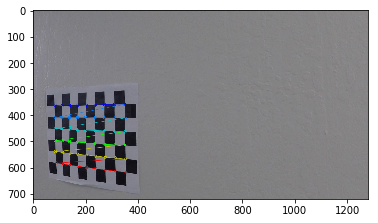

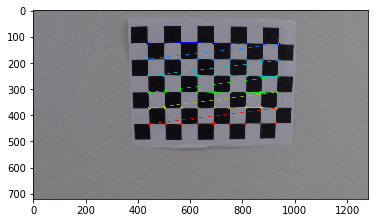

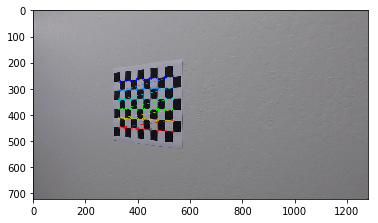

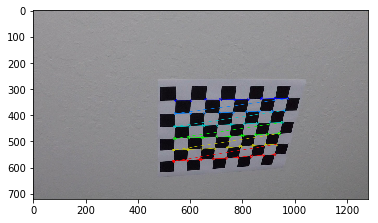

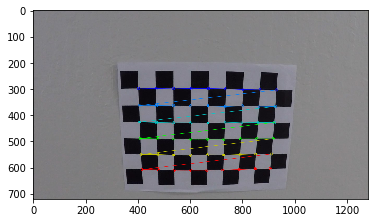

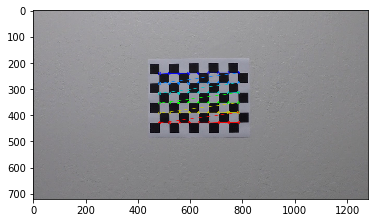

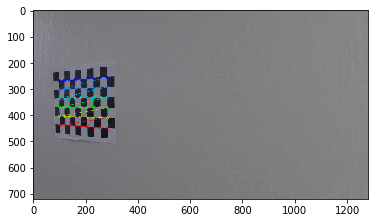

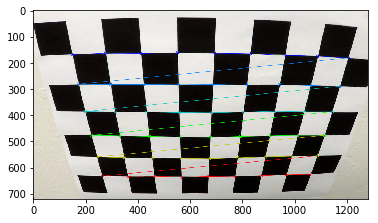

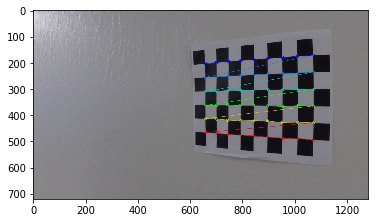

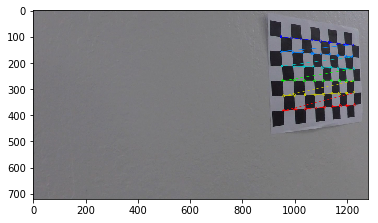

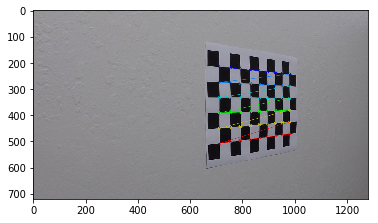

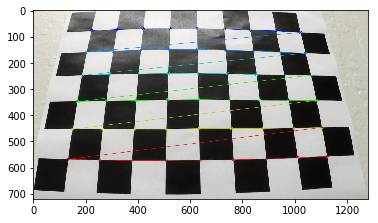

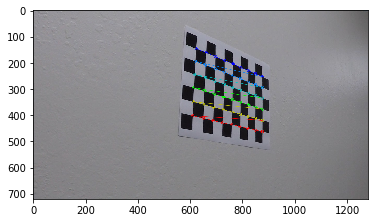

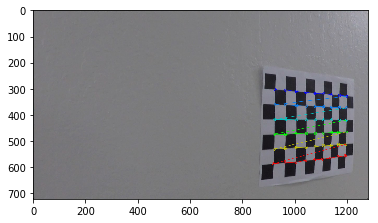

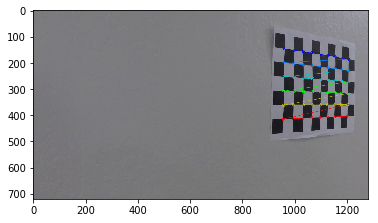

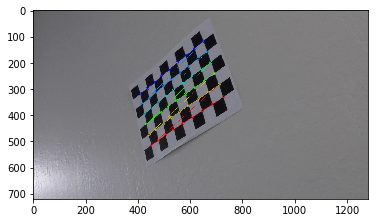

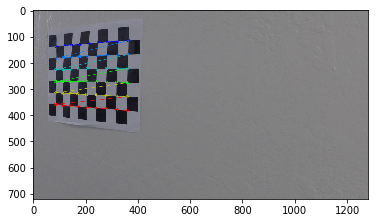

In [14]:
# Camera calibration

# Reading all calibration images' path
fnames = glob.glob('./camera_cal/calibration*.jpg')

# objpoints and imgpoints are corresponding points in object space and image space that we need to find the distortion coefficients
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

# Generating objpoints and imgpoints for each calibration image 
for fname in fnames:
    # prepare object points for each calibration image
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates
    # read image
    img = mpimg.imread(fname)
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    # if corners are found, add object points, image points to the arrays
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # drawing to display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        plt.imshow(img)
        plt.show()

In [16]:
# Reading in a test image to get its shape
test_img = mpimg.imread('./test_images/test1.jpg')
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Getting distortion coefficients from objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_gray.shape[::-1], None, None)

# Defining a function that removes camera distortion
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

### Thresholding


In [76]:
# Reading and storing all test images after undistortion in a list for testing
fnames = glob.glob('./test_images/test*.jpg')

originals = []

for fname in fnames:
    img = mpimg.imread(fname)
    undist = undistort(img)
    originals.append(undist)
    
# Setting up a function to plot test images from a list like above
def plot_images(image_list):
    rows = 2
    cols = 3
    f,ax = plt.subplots(rows,cols,figsize=(20,int(13*rows/cols)))
    for i in range(len(image_list)):
        image = image_list[i]
        ax[int(i/cols),i%cols].imshow(image, cmap = 'gray')
    

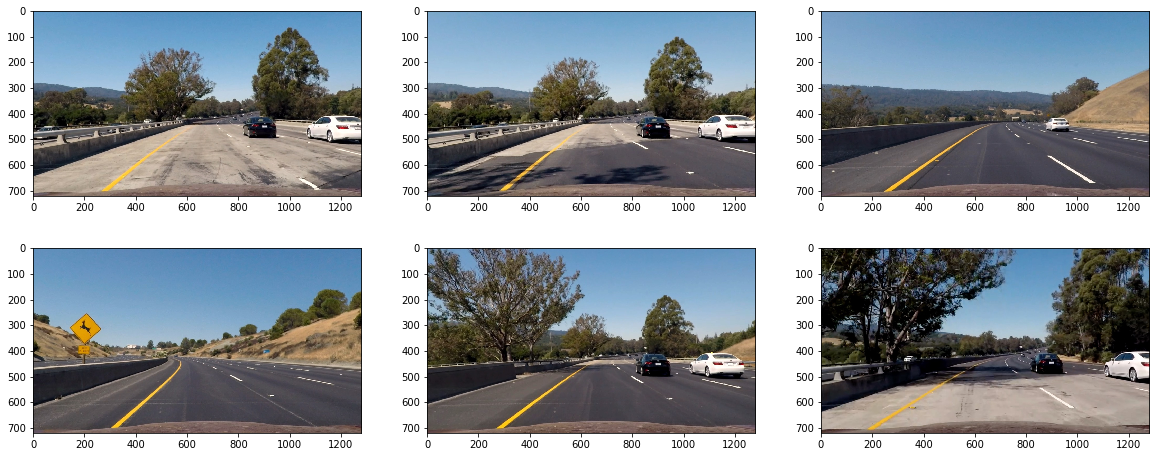

In [77]:
# Original undistorted test images
plot_images(originals)

L channel


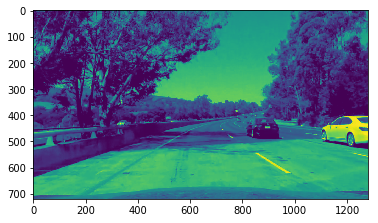

S channel


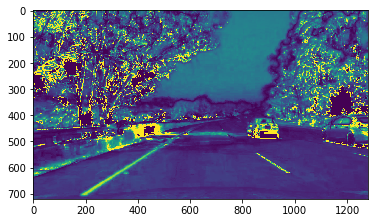

G channel


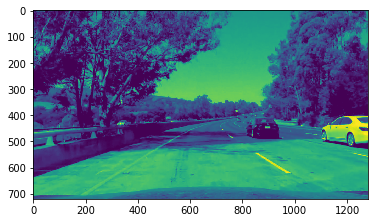

In [36]:
# Choosing test image
test_img = originals[5]

# Exploring color spaces and color channel on our test image
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

# lightness channel from HLS space can be used to identify shadows
l_channel = hls[:,:,1]
print('L channel')
plt.imshow(l_channel)
plt.show()

# saturation channel from HLS space can be used to identify yellow lane pixels
s_channel = hls[:,:,2]
print('S channel')
plt.imshow(s_channel)
plt.show()

# g channel from RGB space can be used to pick up white lane pixels
g_channel = test_img[:,:,1]
print('G channel')
plt.imshow(g_channel)
plt.show()


In [65]:
# Defining helper function for thresholding

# thresh_inside() removes pixels within the threshold range
def thresh_inside(channel_image, channel_threshold):
    # getting range from channel_threshold
    thresh_min = channel_threshold[0]
    thresh_max = channel_threshold[1]
    binary = np.zeros_like(channel_image)
    binary[(channel_image >= thresh_min) & (channel_image <= thresh_max)] = 1
    return binary

# thresh_outside() retains pixels within th threshold range 
def thresh_outside(channel_image, channel_threshold):
    # getting range from channel_threshold
    thresh_min = channel_threshold[0]
    thresh_max = channel_threshold[1]
    binary = np.zeros_like(channel_image)
    binary[(channel_image <= thresh_min) | (channel_image >= thresh_max)] = 1
    return binary

In [66]:
# Defining functions that removes pixels using threshold values from thresholds dictionary

def apply_thresholds(image, thresholds):
    # Convert to HLS color space and separate the S and L channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # G channel from image that is in RGB space
    g_channel = image[:,:,1]
    
    # Threshold s channel from the external thresholds dictionary
    s_threshold = thresholds['s_channel']
    s_binary = thresh_inside(s_channel, s_threshold)
    
    # Threshold l channel from the external thresholds dictionary
    l_threshold = thresholds['l_channel']
    l_binary = thresh_outside(l_channel, l_threshold)
    
    # Threshold g channel from the external thresholds dictionary
    g_threshold = thresholds['g_channel']
    g_binary = thresh_inside(g_channel, g_threshold)

    # Combine the three binary thresholds such that we retain only yellow and white lane pixels while rejecting shadow pixels
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) | (g_binary == 1)) & (l_binary == 0)] = 1
    
    # Return the combined binary image
    return combined_binary

In [95]:
# Defining the thresholds for varios color channels in the thresholds dictionary
thresholds = {
    's_channel': [200, 255],
    'l_channel': [25, 255],
    'g_channel': [208, 255]
}

# and testing on the originals
thresholded_images = []

for image in originals:
    thresholded = apply_thresholds(image, thresholds)
    thresholded_images.append(thresholded)


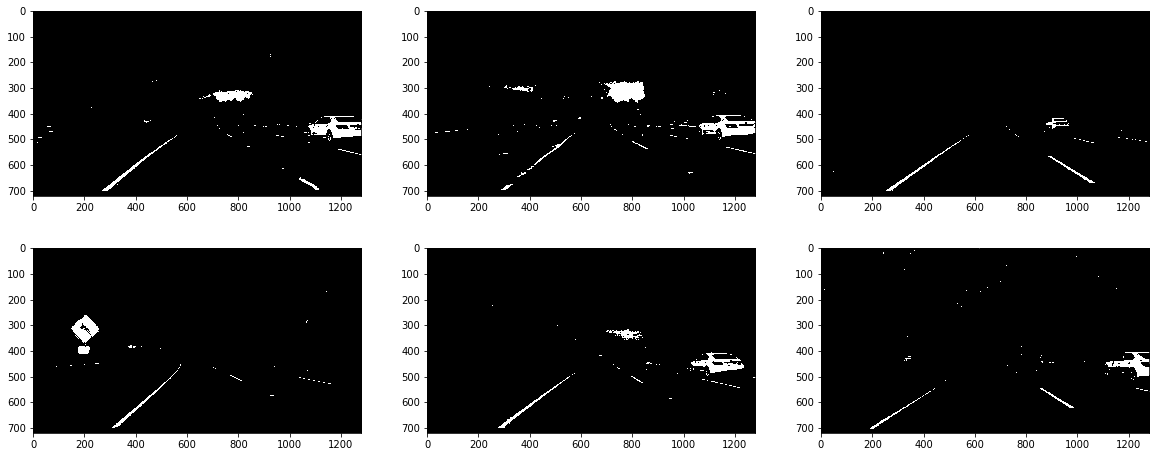

In [96]:
plot_images(thresholded_images)

### Perspective transform

In [97]:
# Defining of the source and destination points is done manually by looking at the straight lane line images
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])

# M defines the transformation matrix from first person view as we have to bird's eye view of the road 
M = cv2.getPerspectiveTransform(src, dst)

# Minv is the reverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)

# warp() is a function that uses M to get the bird's eye view of the road
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [98]:
# Testing warp() on our test images that have been thresholded

warped_images = []

for image in thresholded_images:
    warped = warp(image)
    warped_images.append(warped)

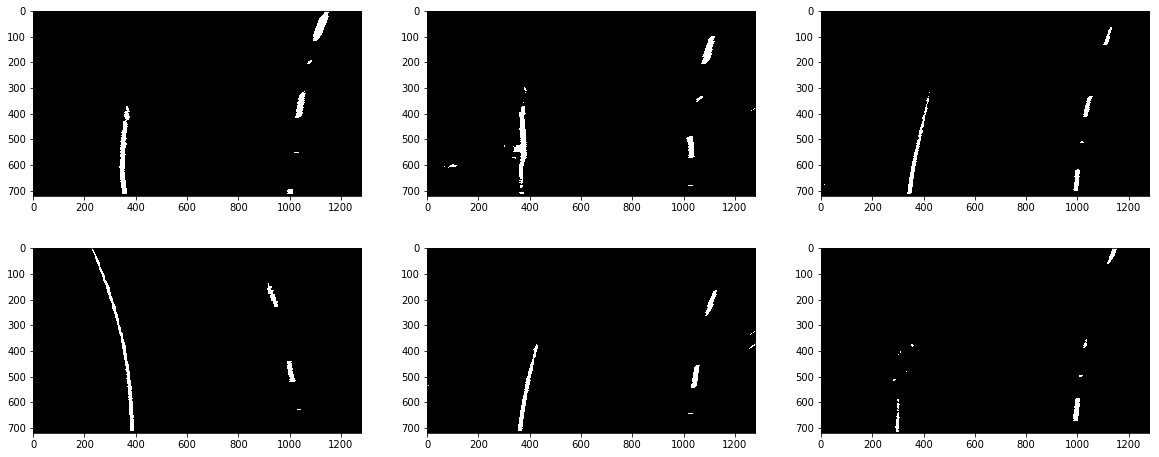

In [99]:
plot_images(warped_images)

#### Finding lines

In [ ]:
# find_lines_initial() finds lines in an image which doesn't supersede any other image

def find_lines_initial(image):
    